<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Cleaning-and-Feature-Engineering" data-toc-modified-id="Data-Cleaning-and-Feature-Engineering-1">Data Cleaning and Feature Engineering</a></span></li><li><span><a href="#Podcast-Date-/-Time-Series-Features" data-toc-modified-id="Podcast-Date-/-Time-Series-Features-2">Podcast Date / Time Series Features</a></span></li><li><span><a href="#Social-Feed-/-External-Site-Classifications" data-toc-modified-id="Social-Feed-/-External-Site-Classifications-3">Social Feed / External Site Classifications</a></span></li><li><span><a href="#Topic-Analysis-Of-Channel-Description" data-toc-modified-id="Topic-Analysis-Of-Channel-Description-4">Topic Analysis Of Channel Description</a></span><ul class="toc-item"><li><span><a href="#Description-Length" data-toc-modified-id="Description-Length-4.1">Description Length</a></span></li></ul></li></ul></div>

In [84]:
import pickle
import copy
import sys, os

from datetime import datetime
import time

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)

import math
import random

import re
import string

import features
from importlib import reload

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

In [70]:
# Load raw scraped channel data

with open('../scraped/merged/merged_10-08_13-54.pickle','rb') as file:
    df = pickle.load(file)

print('shape: ', df.shape)
print('columns:\n',df.columns.values)
df.sample(1)

shape:  (7777, 15)
columns:
 ['title' 'chan_url' 'num_comments' 'author' 'isExplicit' 'sub_count'
 'play_count' 'ch_feed-socials' 'ep_total' 'recent_eps'
 'hover_text_concat' 'chan_desc' 'cover_img_url' 'first_release'
 'category']


,title,chan_url,num_comments,author,isExplicit,sub_count,play_count,ch_feed-socials,ep_total,recent_eps,hover_text_concat,chan_desc,cover_img_url,first_release,category
97,Thompson & Associates,https://castbox.fm/channel/Thompson-%26-Associ...,0,Thompson & Associates,0,8,39,[https://ceplan.podomatic.com],64,"[[2019-09-25, 00:13:47, 0], [2019-09-19, 00:13...","In the second episode of the series, Eddie tal...",Thompson & Associates partners with nonprofits...,https://is5-ssl.mzstatic.com/image/thumb/Podca...,2014-01-30,Non-profit


## Data Cleaning and Feature Engineering

## Podcast Date / Time Series Features

Use the `recent_eps` column, along with the `first_release` column to build features that assess recency, frequency, and age of podcast.

We'll build feature functions from a single podcast as a sample.

In [3]:
df.iloc[0]

title                                                        Fresh Air
chan_url                 https://castbox.fm/channel/Fresh-Air-id431951
num_comments                                                       126
author                                                             NPR
isExplicit                                                           0
sub_count                                                       167880
play_count                                                     4705927
ch_feed-socials      [https://twitter.com/nprfreshair, https://www....
ep_total                                                            50
recent_eps           [[2019-10-03, 00:48:44, 0], [2019-10-02, 00:49...
hover_text_concat    President Trump made building a border wall be...
chan_desc            Fresh Air from WHYY, the Peabody Award-winning...
cover_img_url        https://is3-ssl.mzstatic.com/image/thumb/Podca...
first_release                                               2019-08-07
descri

In [4]:
sample_eps = df.iloc[0].recent_eps
sample_eps

[['2019-10-03', '00:48:44', 0],
 ['2019-10-02', '00:49:21', 6],
 ['2019-10-01', '00:49:13', 4],
 ['2019-09-30', '00:50:06', 4],
 ['2019-09-27', '00:50:24', 2],
 ['2019-09-27', '00:48:28', 1],
 ['2019-09-26', '00:48:59', 9],
 ['2019-09-25', '00:49:41', 2],
 ['2019-09-24', '00:49:44', 11],
 ['2019-09-23', '00:49:55', 4]]

In [29]:
# Let's build a column called 'recent_ep_rate'
# which calculates the average days b/t episode releases
# for the last 10 or so episodes.

def convert_ep_date(string):
    return datetime.strptime(string, '%Y-%m-%d')

def recent_ep_mean_dist(recent_eps):
    ep_list = [convert_ep_date(ep[0]) for ep in recent_eps]
#     print(ep_list)
    
    days_bt_eps = []
    for i in range(len(ep_list)-1):
        days_bt_eps += [abs(ep_list[i+1] - ep_list[i])]

    return pd.Series(days_bt_eps).dt.days.mean()
    

recent_ep_mean_dist(sample_eps)

1.1111111111111112

Load feature column into dataframe.

In [6]:
ep_cols = ['title', 'play_count', 'ep_total','first_release','recent_eps','recent_ep_spacing']
df['recent_ep_spacing'] = df.recent_eps.apply(recent_ep_mean_dist)
df[ep_cols].head(3)

,title,play_count,ep_total,first_release,recent_eps,recent_ep_spacing
0,Fresh Air,4705927,50,2019-08-07,"[[2019-10-03, 00:48:44, 0], [2019-10-02, 00:49...",1.111111
1,The Moth,2419216,157,2017-03-28,"[[2019-10-01, 00:51:10, 8], [2019-09-24, 00:51...",4.666667
2,TED Talks Daily,27571564,975,2016-02-08,"[[2019-10-03, 00:13:43, 3], [2019-10-02, 00:16...",1.111111


Let's build a column called `lifetime_ep_freq` which takes first and last episode date, and divides that distance by total.

In [14]:
test = convert_ep_date('2019-10-03')

In [15]:
test_2 = convert_ep_date('2019-11-03')

In [17]:
delta = (test_2 - test)

In [19]:
delta.total_seconds()

2678400.0

In [ ]:
ep_cols_2 = ep_cols + ['lifetime_ep_freq']


def lifetime_ep_freq(row):
    '''
    
    approx. episodes / day
    
    =  [ep count] / [age of podcast (up to last activity) in days]
    
    Example:
    df['lifetime_ep_freq'] = df.apply(lifetime_ep_freq, axis=1)
    
    '''
    
    last_ep_date = convert_ep_date(row['recent_eps'][0][0])
    release_date = convert_ep_date(row['first_release'])
    ep_total = row['ep_total']
    
    
    
    age = (last_ep_date - release_date).total_seconds() / (24. * 60. * 60.)
    
    if age == 0:
        freq = 0
    else:
        freq = ep_total / age

    print(last_ep_date, release_date, ep_total, age, freq)

        
    return freq
    
    
df['lifetime_ep_freq'] = df.apply(lifetime_ep_freq, axis=1)
df[ep_cols_2].head(3)

Let's calculate average episode length for the `recent_eps` and save as `avg_ep_len`.

In [83]:
ep_cols_3 = ep_cols_2 + ['avg_ep_len']

def avg_ep_len(recent_eps):
    '''
    
    Average length of recent 10 or so episodes.
    
    '''
    ep_lens = [time.strptime(ep[1], '%H:%M:%S') for ep in recent_eps]
    
#     print(ep_lens)
    avg_ep_len = np.mean(ep_lens)

    return avg_ep_len
    
    
df['avg_ep_len'] = df.recent_eps.apply(avg_ep_len) 
df[ep_cols_3].head(3)

,title,play_count,ep_total,first_release,recent_eps,recent_ep_spacing,lifetime_ep_freq,avg_ep_len
0,Fresh Air,4705927,50,2019-08-07,"[[2019-10-03, 00:48:44, 0], [2019-10-02, 00:49...",1.111111,1.140000,220.488889
1,The Moth,2419216,157,2017-03-28,"[[2019-10-01, 00:51:10, 8], [2019-09-24, 00:51...",4.666667,5.840764,219.144444
2,TED Talks Daily,27571564,975,2016-02-08,"[[2019-10-03, 00:13:43, 3], [2019-10-02, 00:16...",1.111111,1.367179,216.344444


## Social Feed / External Site Classifications

Create feature columns to describe quantity of social/external feeds.

Additional scraping of each social feed to assess activity of feed will follow.

In [179]:
social_cols = ['title','play_count', 'ch_feed-socials']
df[social_cols].head(3)

,title,play_count,ch_feed-socials
0,Fresh Air,4705927,"[https://twitter.com/nprfreshair, https://www...."
1,The Moth,2419216,"[https://twitter.com/TheMoth, https://www.face..."
2,TED Talks Daily,27571564,"[https://twitter.com/TEDTalks, https://www.fac..."


In [98]:
# First, let's print a bunch of these feeds, so we know the overall format.
for label, content in df['ch_feed-socials'].sample(10).items():
    print('content:', content, sep='\n')

content:
['https://twitter.com/snapjudgment', 'https://www.facebook.com/SnapJudgment', 'https://www.wnycstudios.org/podcasts/snapjudgment']
content:
['https://twitter.com/LaurenConrad', 'https://www.facebook.com/laurenconrad', 'https://laurenconrad.com/']
content:
['https://twitter.com/TEDTalks', 'https://www.facebook.com/TED', 'https://www.instagram.com/ted', 'https://www.youtube.com/TEDtalksDirector', 'https://www.ted.com/talks']
content:
[]
content:
['https://twitter.com/RISKshow', 'https://www.facebook.com/riskshow', 'http://www.risk-show.com']
content:
['https://twitter.com/TheMoth', 'https://www.facebook.com/TheMoth', 'https://www.instagram.com/mothstories', 'https://www.youtube.com/mothstories', 'http://themoth.org/']
content:
['https://twitter.com/MythPodcast', 'https://www.facebook.com/mythpodcast', 'https://www.instagram.com/mythpodcast', 'https://www.youtube.com/channel/UCM54A0R5z0BwMpEWVYtqbkQ', 'http://www.mythpodcast.com']
content:
['https://twitter.com/TraderJoesList', '

In [160]:
def has_domain(row, social_domain):
#     print(row)
    ch_feed_socials = row
    for link in ch_feed_socials:
        pattern = '.*' + social_domain + '.*'
#         print(pattern, link)
#         print(re.match(pattern, link))
        if re.match(pattern, link):
            return 1
    return 0

In [188]:
social_domain = 'twitter'
df[social_domain] = df['ch_feed-socials'][:10].apply(has_domain,social_domain=social_domain)

social_domains = ['twitter', 'facebook', 'youtube', 'instagram']

for domain in social_domains:
    df[domain] = df['ch_feed-socials'].apply(has_domain,social_domain=domain)

In [189]:
df

,title,chan_url,num_comments,author,isExplicit,sub_count,play_count,ch_feed-socials,ep_total,recent_eps,...,first_release,description,recent_ep_rate,lifetime_ep_freq,avg_ep_len,recent_ep_spacing,twitter,facebook,youtube,instagram
0,Fresh Air,https://castbox.fm/channel/Fresh-Air-id431951,126,NPR,0,167880,4705927,"[https://twitter.com/nprfreshair, https://www....",50,"[[2019-10-03, 00:48:44, 0], [2019-10-02, 00:49...",...,2019-08-07,NaN,1.111111,1.140000,220.488889,1.111111,1,1,1,1
1,The Moth,https://castbox.fm/channel/The-Moth-id12,129,The Moth,0,143346,2419216,"[https://twitter.com/TheMoth, https://www.face...",157,"[[2019-10-01, 00:51:10, 8], [2019-09-24, 00:51...",...,2017-03-28,NaN,4.666667,5.840764,219.144444,4.666667,1,1,1,1
2,TED Talks Daily,https://castbox.fm/channel/TED-Talks-Daily-id4541,710,TED,0,1382334,27571564,"[https://twitter.com/TEDTalks, https://www.fac...",975,"[[2019-10-03, 00:13:43, 3], [2019-10-02, 00:16...",...,2016-02-08,NaN,1.111111,1.367179,216.344444,1.111111,1,1,1,1
3,99% Invisible,https://castbox.fm/channel/id18,208,Roman Mars,0,177413,3149718,"[https://twitter.com/romanmars, http://99perce...",404,"[[2019-10-01, 00:33:53, 11], [2019-09-24, 00:4...",...,2010-09-23,NaN,7.000000,8.155941,217.844444,7.000000,1,0,0,0
4,Snap Judgment Presents: Spooked,https://castbox.fm/channel/Snap-Judgment-Prese...,208,Snap Judgment and WNYC Studios,0,23327,322310,"[https://twitter.com/SpookedPod, https://www.f...",36,"[[2019-09-19, 00:21:11, 7], [2019-09-13, 00:30...",...,2017-09-01,NaN,37.444444,20.777778,218.022222,37.444444,1,1,0,0
5,Myths and Legends,https://castbox.fm/channel/Myths-and-Legends-i...,327,Jason Weiser Carissa Weiser / Bardic,0,152126,2568707,"[https://twitter.com/MythPodcast, https://www....",224,"[[2019-10-01, 00:39:57, 4], [2019-09-24, 00:40...",...,2015-04-27,NaN,7.000000,7.223214,219.344444,7.000000,1,1,1,1
6,Nice Try!,https://castbox.fm/channel/Nice-Try!-id2112178,6,Curbed,0,17593,58893,"[https://twitter.com/curbed, https://www.faceb...",9,"[[2019-08-15, 00:46:51, 5], [2019-07-18, 00:36...",...,2019-05-03,NaN,13.000000,11.555556,219.000000,13.000000,1,1,0,1
7,Snap Judgment,https://castbox.fm/channel/Snap-Judgment-id131,127,Snap Judgment and WNYC Studios,0,43501,829582,"[https://twitter.com/snapjudgment, https://www...",248,"[[2019-09-26, 00:28:37, 8], [2019-09-19, 00:36...",...,2015-10-16,NaN,5.444444,5.810484,217.400000,5.444444,1,1,0,0
8,The Beauty Closet,https://castbox.fm/channel/The-Beauty-Closet-i...,1,Goop Inc and Cadence 13,0,354,4732,[https://goop.com/thepodcast],11,"[[2019-09-25, 00:43:28, 1], [2019-09-18, 00:50...",...,2019-07-09,NaN,7.000000,7.090909,219.166667,7.000000,0,0,0,0
9,LeVar Burton Reads,https://castbox.fm/channel/LeVar-Burton-Reads-...,153,LeVar Burton and Stitcher,1,29068,493187,"[https://twitter.com/levarburton, https://www....",75,"[[2019-10-01, 00:52:15, 5], [2019-09-24, 00:39...",...,2017-06-02,NaN,9.444444,11.346667,219.755556,9.444444,1,1,0,0


In [184]:
all_social_cols = social_cols.extend(social_domains)
df[all_social_cols].head(10)

KeyError: None

In [170]:
re.match('.*twitter.*','https://twitter.com/nprfreshair').group()

'https://twitter.com/nprfreshair'

In [180]:
social_cols.extend(social_domains)

In [181]:
social_cols

['title',
 'play_count',
 'ch_feed-socials',
 'twitter',
 'facebook',
 'youtube',
 'instagram']

In [190]:
df

,title,chan_url,num_comments,author,isExplicit,sub_count,play_count,ch_feed-socials,ep_total,recent_eps,...,first_release,description,recent_ep_rate,lifetime_ep_freq,avg_ep_len,recent_ep_spacing,twitter,facebook,youtube,instagram
0,Fresh Air,https://castbox.fm/channel/Fresh-Air-id431951,126,NPR,0,167880,4705927,"[https://twitter.com/nprfreshair, https://www....",50,"[[2019-10-03, 00:48:44, 0], [2019-10-02, 00:49...",...,2019-08-07,NaN,1.111111,1.140000,220.488889,1.111111,1,1,1,1
1,The Moth,https://castbox.fm/channel/The-Moth-id12,129,The Moth,0,143346,2419216,"[https://twitter.com/TheMoth, https://www.face...",157,"[[2019-10-01, 00:51:10, 8], [2019-09-24, 00:51...",...,2017-03-28,NaN,4.666667,5.840764,219.144444,4.666667,1,1,1,1
2,TED Talks Daily,https://castbox.fm/channel/TED-Talks-Daily-id4541,710,TED,0,1382334,27571564,"[https://twitter.com/TEDTalks, https://www.fac...",975,"[[2019-10-03, 00:13:43, 3], [2019-10-02, 00:16...",...,2016-02-08,NaN,1.111111,1.367179,216.344444,1.111111,1,1,1,1
3,99% Invisible,https://castbox.fm/channel/id18,208,Roman Mars,0,177413,3149718,"[https://twitter.com/romanmars, http://99perce...",404,"[[2019-10-01, 00:33:53, 11], [2019-09-24, 00:4...",...,2010-09-23,NaN,7.000000,8.155941,217.844444,7.000000,1,0,0,0
4,Snap Judgment Presents: Spooked,https://castbox.fm/channel/Snap-Judgment-Prese...,208,Snap Judgment and WNYC Studios,0,23327,322310,"[https://twitter.com/SpookedPod, https://www.f...",36,"[[2019-09-19, 00:21:11, 7], [2019-09-13, 00:30...",...,2017-09-01,NaN,37.444444,20.777778,218.022222,37.444444,1,1,0,0
5,Myths and Legends,https://castbox.fm/channel/Myths-and-Legends-i...,327,Jason Weiser Carissa Weiser / Bardic,0,152126,2568707,"[https://twitter.com/MythPodcast, https://www....",224,"[[2019-10-01, 00:39:57, 4], [2019-09-24, 00:40...",...,2015-04-27,NaN,7.000000,7.223214,219.344444,7.000000,1,1,1,1
6,Nice Try!,https://castbox.fm/channel/Nice-Try!-id2112178,6,Curbed,0,17593,58893,"[https://twitter.com/curbed, https://www.faceb...",9,"[[2019-08-15, 00:46:51, 5], [2019-07-18, 00:36...",...,2019-05-03,NaN,13.000000,11.555556,219.000000,13.000000,1,1,0,1
7,Snap Judgment,https://castbox.fm/channel/Snap-Judgment-id131,127,Snap Judgment and WNYC Studios,0,43501,829582,"[https://twitter.com/snapjudgment, https://www...",248,"[[2019-09-26, 00:28:37, 8], [2019-09-19, 00:36...",...,2015-10-16,NaN,5.444444,5.810484,217.400000,5.444444,1,1,0,0
8,The Beauty Closet,https://castbox.fm/channel/The-Beauty-Closet-i...,1,Goop Inc and Cadence 13,0,354,4732,[https://goop.com/thepodcast],11,"[[2019-09-25, 00:43:28, 1], [2019-09-18, 00:50...",...,2019-07-09,NaN,7.000000,7.090909,219.166667,7.000000,0,0,0,0
9,LeVar Burton Reads,https://castbox.fm/channel/LeVar-Burton-Reads-...,153,LeVar Burton and Stitcher,1,29068,493187,"[https://twitter.com/levarburton, https://www....",75,"[[2019-10-01, 00:52:15, 5], [2019-09-24, 00:39...",...,2017-06-02,NaN,9.444444,11.346667,219.755556,9.444444,1,1,0,0


In [30]:
with open('../scraped/channel/podcast_chan_dict-corrected-urls-v2.pickle', 'rb') as file:
    chan_dict = pickle.load(file)

In [32]:
len(chan_dict.keys())

116

## Topic Analysis Of Channel Description

In [102]:
text_df = df[(df.play_count < 1000000.0) & (df.play_count > 50)][['play_count', 'title', 'chan_desc','hover_text_concat']]
text_df.sample()

,play_count,title,chan_desc,hover_text_concat
169,143,The PBSCCS Podcast,The Professional Baseball Strength and Conditi...,Taylor Haslinger is a native of southwest Flor...


In [103]:
text_df.dtypes

play_count            int64
title                object
chan_desc            object
hover_text_concat    object
dtype: object

In [104]:
text_df.shape

(6515, 4)

### Description Length

In [105]:
def calc_avg_desc_len(hover_text):
    
    try:
        ep_desc_list = hover_text.split('|')
#     print(ep_desc_list)
        return np.mean([len(d) for d in ep_desc_list])
    except:
        return 0

In [106]:
text_df['avg_ep_desc_len'] = text_df.hover_text_concat.apply(calc_avg_desc_len)

In [125]:
text_df.sort_values(by='play_count', ascending=False)[10:20]

,play_count,title,chan_desc,hover_text_concat,avg_ep_desc_len,log_desc_len
19,916700,The Goal Digger Podcast,How do I build my dream job? How do I make mon...,This is your permission to take a day off. Act...,1105.7,7.0
59,914546,The Brilliant Idiots,Charlamagne Tha God and Andrew Schulz are The ...,"Andrew is back from Australia, Ryan Holiday dr...",206.1,5.3
9,909541,The Andrew Klavan Show,End of Western Civilization got you down? All ...,The Joker Democrats and the Press scold Americ...,162.8,5.1
26,905361,Louder With Crowder,"Steven Crowder brings you news, entertainment ...",Talking all things Hillary's obsession with Tr...,241.6,5.5
34,904429,Grammar Girl Quick and Dirty Tips for Better W...,WINNER OF BEST EDUCATION PODCAST IN THE 2017 P...,| | | | | | | | |,1.8,0.6
193,903715,6 Minute Vocabulary,NaN,NaN,0.0,-inf
14,894592,All In with Chris Hayes,The biggest news and political stories of the ...,New subpoenas....and a new whistleblower. Ton...,441.5,6.1
109,882717,Real Estate Investing Mastery Podcast,"On the Real Estate Investing Mastery Podcast, ...",Thinking about getting into real estate invest...,719.0,6.6
5,874366,Talk Is Jericho,"He’s a multiple world champion pro wrestler, l...",Heavy Metal Rules! So say Steel Panther! Sing...,636.8,6.5
0,873046,Golic and Wingo,"You know 'em, you love 'em. Longtime friends a...",Jay Gruden was fired by the Redskins after a 3...,157.9,5.1


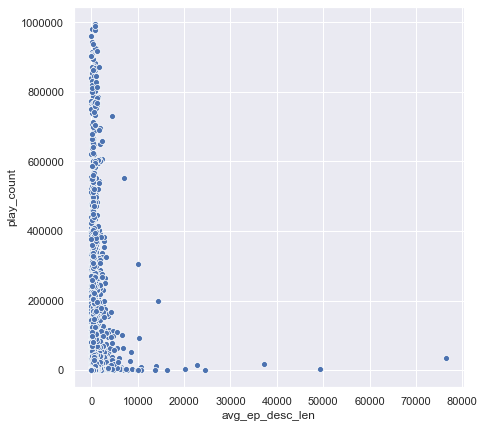

In [108]:
x, y = text_df.avg_ep_desc_len, text_df.play_count

fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x, y)

//anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


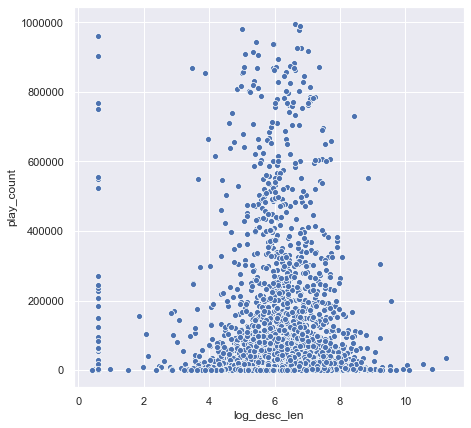

In [110]:
# try a different relationship
text_df['log_desc_len'] = np.log(text_df.avg_ep_desc_len)

x = text_df.log_desc_len
y = text_df.play_count

fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x, y)

Can this be used?

Trying other transformations...

In [128]:
text_df['desc_len_pow2'] = np.power(text_df.avg_ep_desc_len, 2)

In [129]:
text_df.corr()

,play_count,avg_ep_desc_len,log_desc_len,desc_len_pow2
play_count,1.0,-0.0,-0.0,-0.0
avg_ep_desc_len,-0.0,1.0,0.5,0.8
log_desc_len,-0.0,0.5,1.0,0.1
desc_len_pow2,-0.0,0.8,0.1,1.0


In [ ]:
for value in text_df.sort_values(by='play_count', ascending=False)[:2].values:
    print('\n')
    print(value)

In [130]:
df.head()

,title,chan_url,num_comments,author,isExplicit,sub_count,play_count,ch_feed-socials,ep_total,recent_eps,hover_text_concat,chan_desc,cover_img_url,first_release,category
0,At The Table with Patrick Lencioni,https://castbox.fm/channel/At-The-Table-with-P...,0,Patrick Lencioni,0,119,1686,[https://www.tablegroup.com],13,"[[2019-10-02, 00:34:32, 0], [2019-09-25, 00:27...",Without understanding how people are wired it ...,Real conversations and practical advice for ev...,https://is3-ssl.mzstatic.com/image/thumb/Podca...,2019-07-11,Management
1,The Learning Leader Show With Ryan Hawk,https://castbox.fm/channel/The-Learning-Leader...,3,Ryan Hawk,1,1283,31249,[http://LearningLeaderShow.com],331,"[[2019-09-29, 01:03:30, 2], [2019-09-25, 01:14...",The Learning Leader Show With Ryan Hawk Full s...,Leaders are learners. The best leaders never s...,https://is2-ssl.mzstatic.com/image/thumb/Podca...,2015-04-09,Management
2,Transformational Leader Podcast,https://castbox.fm/channel/Transformational-Le...,2,Paul Martinelli and the John Maxwell Team,0,301,2444,[https://johnmaxwellteam.com/],32,"[[2019-10-02, 00:42:30, 0], [2019-09-25, 00:38...",Welcome to this week’s Transformational Leader...,Welcome to the Transformational Leader Podcast...,https://is1-ssl.mzstatic.com/image/thumb/Podca...,2019-03-07,Management
3,"Switch, Pivot or Quit",https://castbox.fm/channel/Switch%2C-Pivot-or-...,3,Mayzie Media,0,684,14210,[https://www.spreaker.com/show/switch-pivot-or...,258,"[[2019-10-02, 01:01:34, 0], [2019-09-25, 00:45...",We check in with Kenecia Lashae of Passport 2 ...,For girlfriend sitting at her day job thinking...,https://is4-ssl.mzstatic.com/image/thumb/Podca...,2017-01-10,Management
4,Rework,https://castbox.fm/channel/Rework-id980288,0,Basecamp,0,1530,32204,[https://rework.fm],84,"[[2019-10-01, 01:07:30, 0], [2019-09-24, 00:32...","Matt Mullenweg, the founding developer of Word...",A podcast by Basecamp about the better way to ...,https://is5-ssl.mzstatic.com/image/thumb/Podca...,2017-07-26,Management
